# Assignment: QAOA for minimum spanning trees.

Finding the minimum spanning tree of an undirected weighted graph is a standard problem in graph theory for which many efficient classical algorithms are known. Algorithms such as Borůvka's, Kruskal's or Prim's algorithm all can solve this problem efficiently in ${\cal O} \left(E \log(N)\right)$ operations, where $E$ is the number of edges in the graph and $N$ the number of nodes. So this will be hard to beat with a quantum algorithm.

### Hybrid approach: mixing quantum and classical algorithms
Nevertheless, it is a good excersise to see if we can get some kind of quantum speedup using the QAOA algorithm. 
The connectivity of the spanning tree is a highly non-local property, so at first I thought it would be hard to program this as a problem Hamiltonian for QAOA. My first idea therefore was to take a hybrid approach, taking a classical algorithm such as Prim's algorithm and to apply the QAOA only for the search if the minimal edge at each step of the classical algorithm. This is similar in line with the method proposed by Dürr *et al.* (SIAM J. Comput., 35(6), 1310, 2006; https://arxiv.org/abs/quant-ph/0401091), where they combine Borůvka's algorithm with a Grover search at each step and obtain a scaling of the order ${\cal O} \left(\sqrt{EN}\right)$.
If QAOA could achieve the same speedup as Grover's algorithm, then a combination of Prim's algorithm with QAOA could obtain a scaling similar to Dürr's method.

### The full quantum: QAOA on a fully connected subspace
Then it occurred to me that it would be possible to set up a complete QAOA procedure provided that the graph was restricted to a maximum degree of 3, i.e. any node does not have more than 3 edges.
This is not really a limitation, because any undirected graph can be transformed to this form by splitting up highly-connected nodes. E.g., a node with 4 edges can be replaced by two nodes connected through a zero-weight link, 
where each node gets 2 of the original edges, so we end up with two nodes of degree 3 instead of one node of degree 4.

#### The mixer Hamiltonian
The trick to make QAOA work for these kind of graphs is to make sure that the mixer only generates connected paths.
To achieve this, I map the edges of the graph to qubits.
The initial state should correspond to some connected graph, but not necessarily a full spanning tree.
Picking one node and flipping the spin on all qubits representing edges into that node makes for a simple but viable starting initial state.
The mixer then combines X gates on each edge, conditioned on the spin of the other edges that connect either to the left or the right node of the first edge ('left' and 'right' do not correspond to any specific orientation, it is just a graphical analog to help visualize the steps).
The condition that I want to implement is that the edge must be 'dangling', 
i.e. it connects an otherwise unconnected node with an already connected node.
One should constrain the X gate on either all left-connected edges having spin down and at least one right-connected edge having spin up, or vice-verse.
This leads to composed gates of the form CRX, CCRX, CCCRX and CCCCRX, depending on the number of connected edges,
and where RX is an X rotation gate controlled by one or more spin-up or spin-down controllers C.

The resulting mixer operator, applied to all edges, is quite deep but guarantees that the state vector will be a superposition only of qubit states that represent fully connected paths.

#### The problem Hamiltonian
The above procedure for the mixer Hamiltonian produces fully connected paths,
but does not guarantee that all nodes are included in those paths.
To assure this, the problem Hamiltonian must include a penalty for any node not connected to the path.
Since our qubits represent edges, the condition implies that we should impose a penalty
if all edges connected to a node have spin down. 
The result is a series of CP, CCP and CCCP gates, depending on the number of edges connected to the node,
and where P is a Phase rotation gate controlled by one or more spin-down controllers C.
In this way, only the states that include at least one edge to each node will escape the penalty.

Finally, one also has to account for the weights of the paths,
which is done by applying an RZ gate to all edges with rotations proportional to the weight of each edge.


#### Extension to higher degrees
In principle, the above ideas could be extended to graphs of higher degree than 3,
but the resulting mixer and penalty operators would become very complicated,
including up to $2D+1$ qubits for each mixer on an edge that connects two nodes of degree $D$.
Decomposing the graph into a graph with more nodes but a lower degree looks more practical.

### QAOA in action

Let's see how QAOA performs for a small weighted graph with 6 nodes and 8 edges, with maximally 3 edges per node.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qaoa_spanning_trees import *

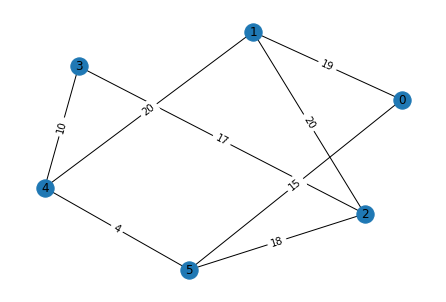

In [2]:
pos = nx.spring_layout(graph, k=20, scale=-1, seed=np_random)
nx.draw(graph, pos, with_labels=True)
nx.draw_networkx_edge_labels(graph, pos, edge_labels=graph.weighted_edges())
plt.show()

In [3]:
beta_gamma = [1.0, 1.0]
length, path = evaulate_params(beta_gamma)
print("length:", length)
path

length: 48


[(0, 1), (0, 5), (3, 4), (4, 5)]

We get a connected path, but it does not include all nodes.
That is because we have not optimized the parameters yet.

I could not get the scipy minimizer to converge yet. 
Instead will use an extremely simple Monte Carlo minimizer in order to get a result.

In [4]:
for it in range(20):
    bg = np_random.rand(2)*2*np.pi
    l, p = evaulate_params(bg)
    if (len(p) > len(path)) or ((len(p)==len(path)) and (l < length)):
        length, path = l, p
        print("length:", length, path)


length: 66 [(0, 5), (1, 4), (2, 3), (3, 4), (4, 5)]


In [5]:
classical = nx.minimum_spanning_tree(graph)
classical_length = sum(data['weight'] for i, j, data in classical.edges(data=True))
print("minimal length:", classical_length, list(classical.edges))

minimal length: 65 [(0, 5), (0, 1), (2, 3), (3, 4), (4, 5)]
